In [19]:
# Importing the libraries
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
%matplotlib inline

## Problem Statement

> **QUESTION**: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, **you're tasked with creating an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits and region of residence. 
>
> Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction.
> 
> You're given a [CSV file](https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv) containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers. 
>
> Dataset source: https://github.com/stedy/Machine-Learning-with-R-datasets

In [20]:
# download the data using the urlretrieve function from urllib.request.
medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'

In [3]:
from urllib.request import urlretrieve

In [4]:
urlretrieve(medical_charges_url, 'medical.csv')

('medical.csv', <http.client.HTTPMessage at 0x1c9f7b1d160>)

In [10]:
# create a Pandas dataframe using the downloaded file, to view and analyze the data.
medical_df = pd.read_csv('medical.csv')
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer. 

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

In [11]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" ([body mass index](https://en.wikipedia.org/wiki/Body_mass_index)) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). 
None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical columns:

In [12]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.

## Exploratory Analysis and Visualization

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

The following settings will improve the default style and font sizes for our charts.

In [21]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [22]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

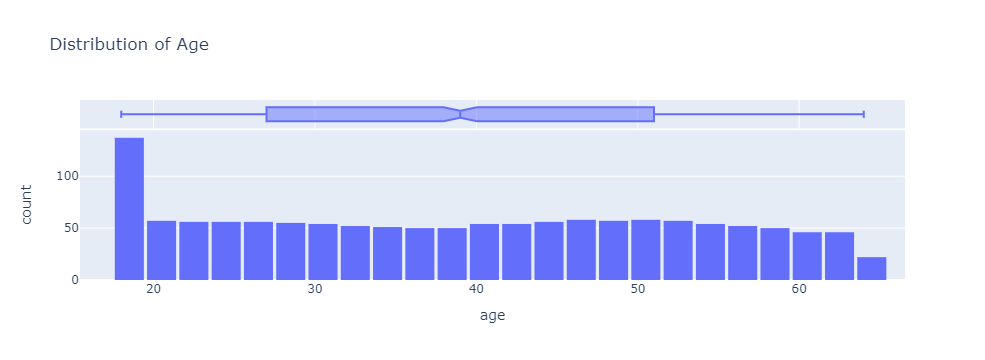

In [23]:
fig = px.histogram(medical_df, x = 'age', marginal = 'box', title = 'Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the [number of people of any given age](https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/) (between 18 & 64) in the USA.

### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

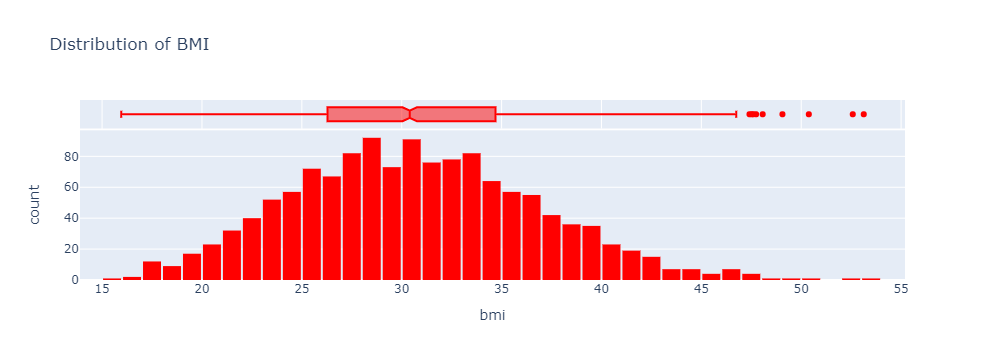

In [24]:
fig = px.histogram(medical_df, x = 'bmi', marginal = 'box',  color_discrete_sequence=['red'], title = 'Distribution of BMI')
fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) centered around the value 30, with a few outliers towards the right.

### Charges

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

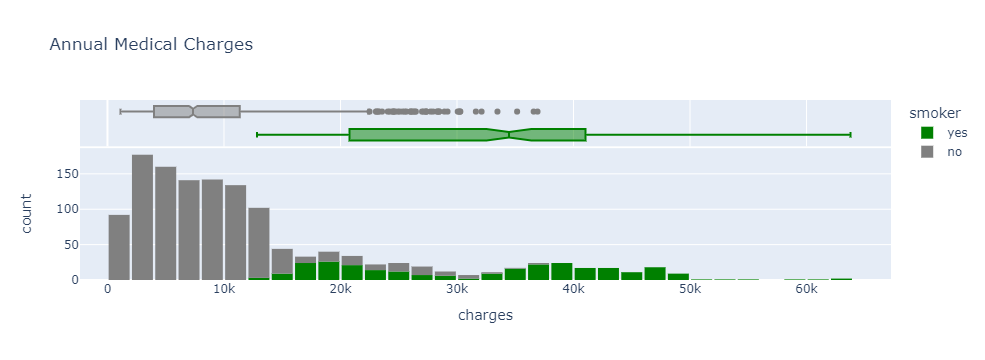

In [25]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

* For most customers, the annual medical charges are under \\$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \\$7300, the median for smokers is close to \\$35,000.

### Charges based on Sex

Let's look at the distribution of medical charges in connection with sex, using a histogram and box plot.

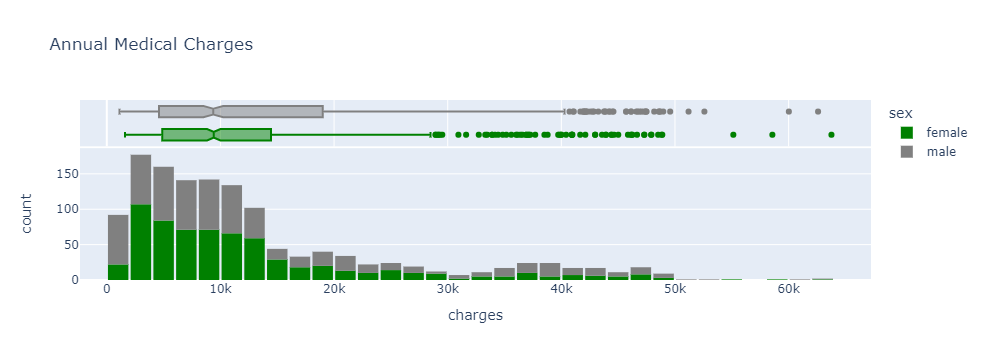

In [26]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='sex', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

### Charges based on Sex

Let's look at the distribution of medical charges in connection with region, using a histogram and box plot.

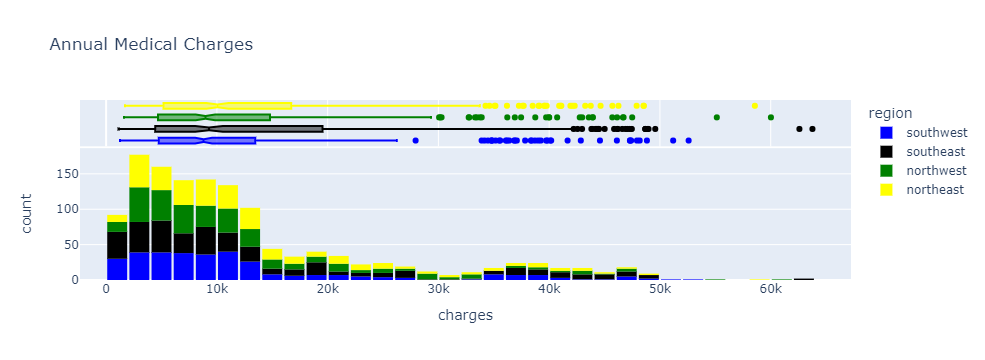

In [27]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='region', 
                   color_discrete_sequence=['blue', 'black', 'green','yellow'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [28]:
medical_df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

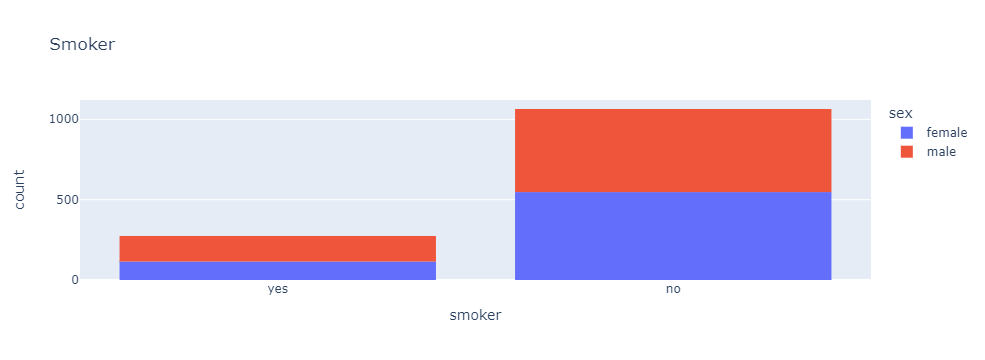

In [29]:
px.histogram(medical_df, x = 'smoker', color='sex', title='Smoker')

It appears that 20% of customers have reported that they smoke. Can you verify whether this matches the national average, assuming the data was collected in 2010? We can also see that smoking appears a more common habit among males.

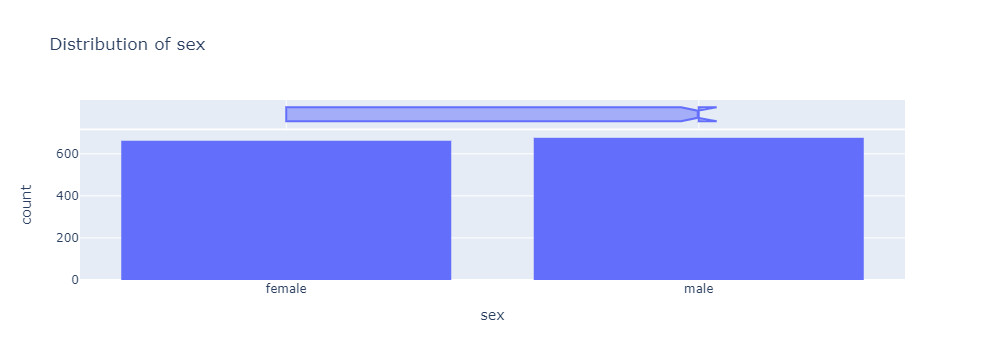

In [30]:
px.histogram(medical_df, x = 'sex', marginal='box', title = 'Distribution of sex')

From the above graphs, it seems that count of medical packages are almost equal in female and male.

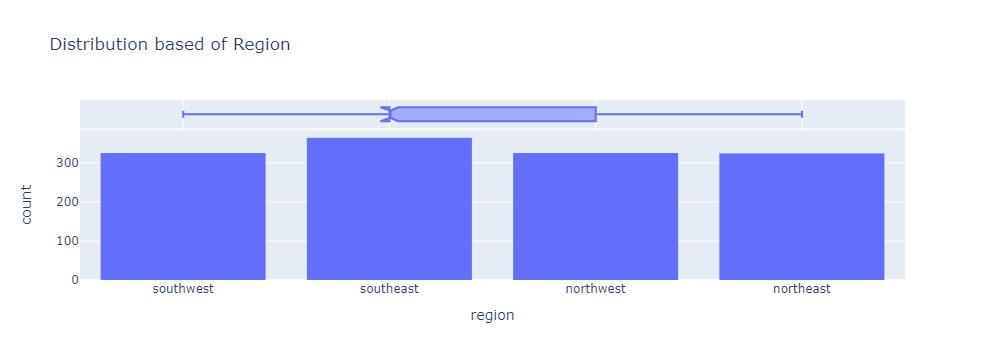

In [31]:
px.histogram(medical_df, x = 'region', marginal='box', title = 'Distribution based of Region')

Southeast areas looks more customers than the other regions.

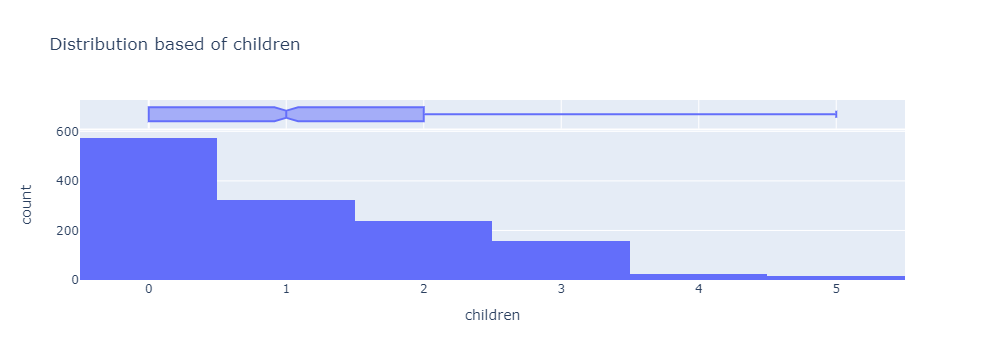

In [13]:
px.histogram(medical_df, x = 'children', marginal='box', title = 'Distribution based of children')

Parents with no children are willing to take health insurance more. Parents with children more than 4 are not willing to take health insurance compare to less children.

Having looked at individual columns, we can now visualize the relationship between "charges" (the value we wish to predict) and other columns.

### Age and Charges

Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

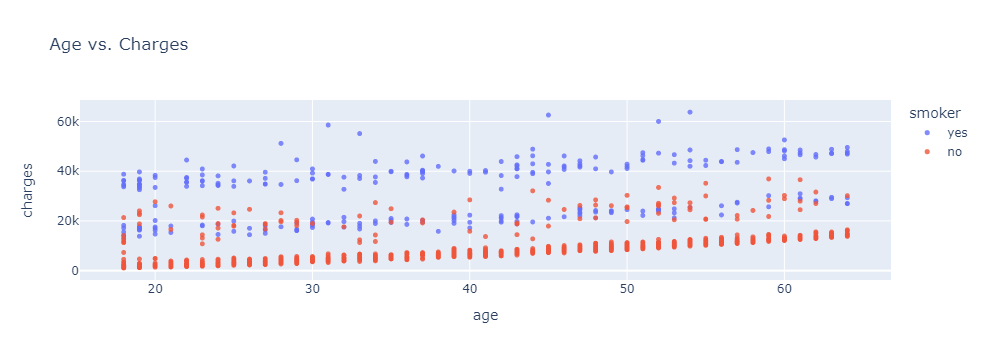

In [14]:
fig = px.scatter(medical_df, x = 'age', y = 'charges', color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

* The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.


* We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

     1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others
     
     2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.   

### BMI and Charges

Let's visualize the relationship between BMI (body mass index) and charges using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

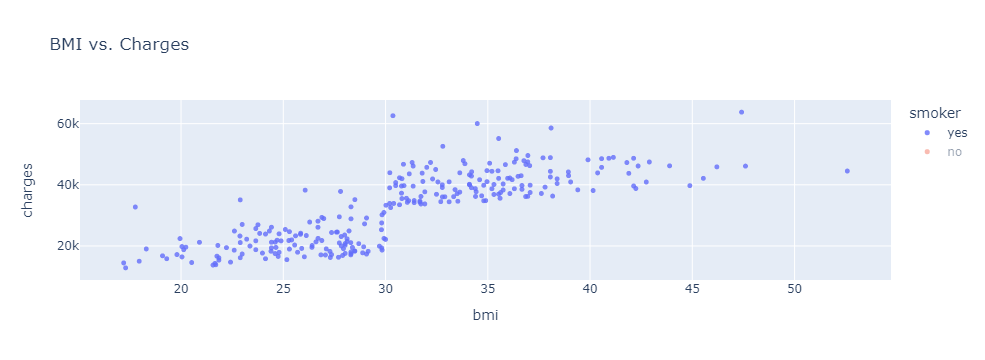

In [15]:
fig = px.scatter(medical_df, x = 'bmi', y = 'charges', color = 'smoker', opacity = 0.8, hover_data=['sex'], title = 'BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.

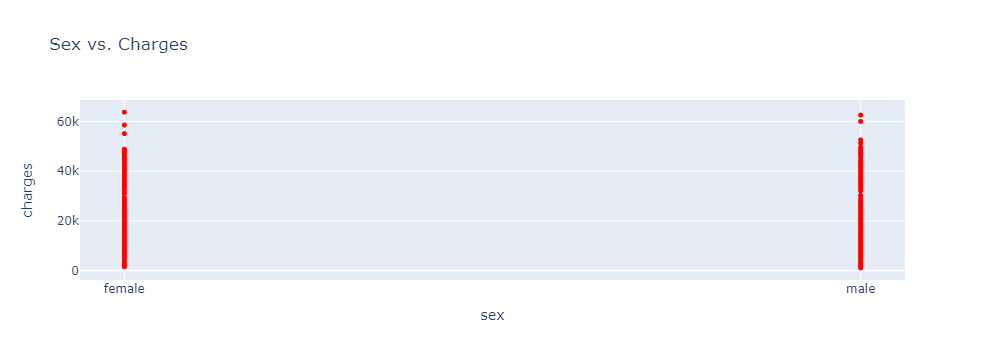

In [19]:
fig = px.scatter(medical_df, x = 'sex', y = 'charges', color_discrete_sequence=['red'], title = 'Sex vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

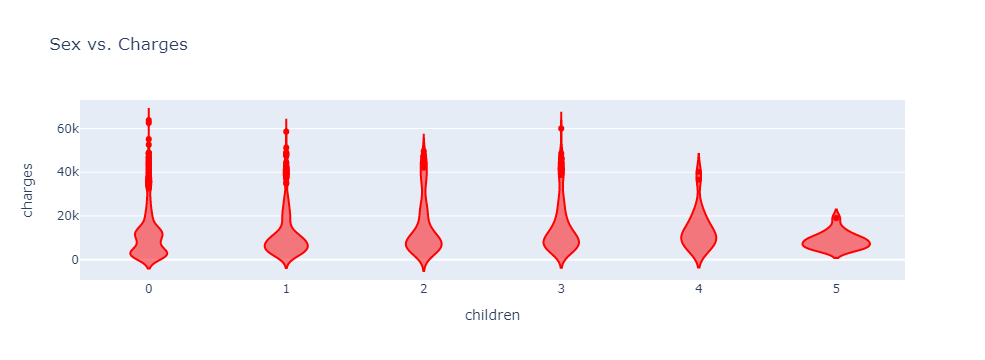

In [25]:
fig = px.violin(medical_df, x = 'children', y = 'charges', color_discrete_sequence=['red'], title = 'Sex vs. Charges')
fig.update_layout(bargap=0.1)
fig.show()

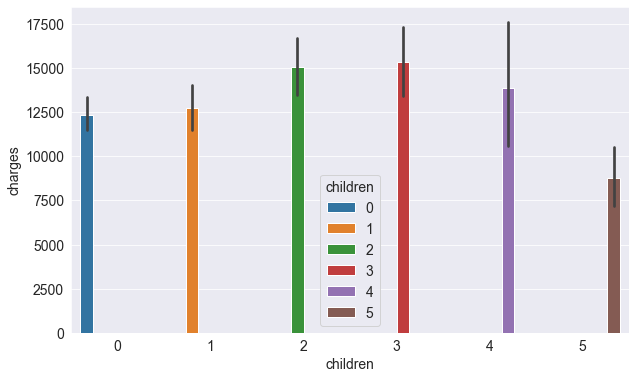

In [29]:
fig = sns.barplot(data = medical_df, x = 'children', y = 'charges', hue="children")

<AxesSubplot:xlabel='smoker', ylabel='charges'>

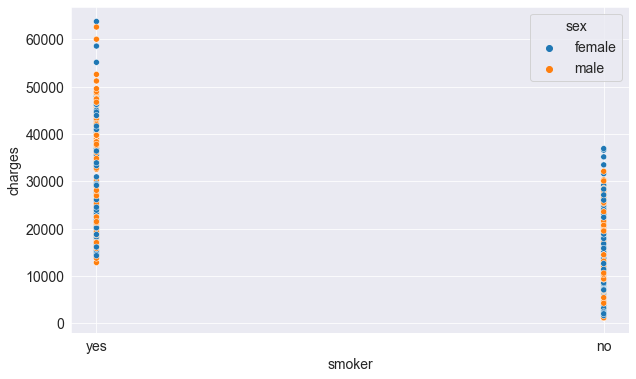

In [32]:
sns.scatterplot(data = medical_df, x = 'smoker', y = 'charges', hue="sex")

It seems like those who are smoking are having more health insurance charges.

### Correlation

As you can tell from the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

This relationship is often expressed numerically using a measure called the _correlation coefficient_, which can be computed using the `.corr` method of a Pandas series.

In [38]:
medical_df.charges.corr(medical_df.age)

0.2990081933306478

In [39]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362887

In [40]:
medical_df.charges.corr(medical_df.children)

0.06799822684790487

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [42]:
sex_count = { 'male' : 0, 'female' : 1 }  
sex_numeric = medical_df.sex.map(sex_count)
medical_df.charges.corr(sex_numeric)

-0.05729206220202533

In [43]:
smoker_count = { 'no' : 0, 'yes' : 1 }
smoker_numeric = medical_df.smoker.map(smoker_count)
medical_df.charges.corr(smoker_numeric)

0.7872514304984778

Pandas dataframes also provide a .corr method to compute the correlation coefficients between all pairs of numeric columns.

In [44]:
medical_df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


The result of `.corr` is called a correlation matrix and is often visualized using a heatmap.

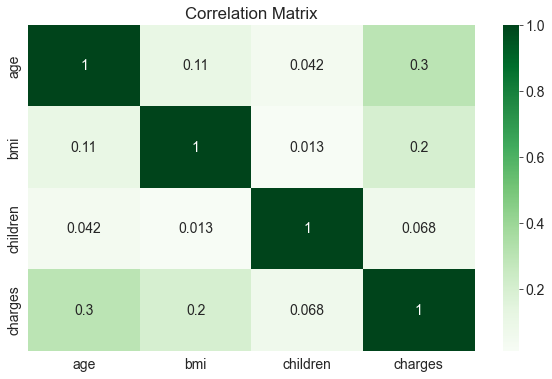

In [45]:
sns.heatmap(medical_df.corr(), cmap = 'Greens', annot = True)
plt.title('Correlation Matrix');

## Linear Regression using a Single Feature

We now know that the "non_smoker" and "age" columns have the strongest correlation with "charges". Let's try to find a way of estimating the value of "charges" using the value of "age" for non-smokers. First, let's create a data frame containing just the data for non-smokers.

In [46]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

Text(0.5, 1.0, 'Age vs. Charges')

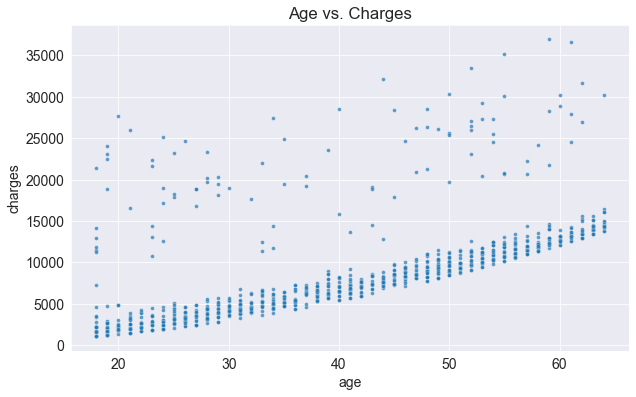

In [48]:
sns.scatterplot(data = non_smoker_df, x = 'age', y = 'charges', alpha = 0.7, s=15)
plt.title('Age vs. Charges')

Apart from a few exceptions, the points seem to form a line. We'll try and "fit" a line using this points, and use the line to predict charges for a given age. A line on the X&Y coordinates has the following formula:

$y = wx + b$

The line is characterized two numbers: $w$ (called "slope") and $b$ (called "intercept"). 

### Model

In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assume the following relationship between the two:

$charges = w \times age + b$
Let define a helper function `estimate_charges`, to compute $charges$, given $age$, $w$ and $b$.

In [49]:
def estimate_charges(age, w, b):
    return w * age + b

The `estimate_charges` function is our very first _model_.

Let's _guess_ the values for $w$ and $b$ and use them to estimate the value for charges.

In [50]:
w = 50
b = 100

In [ ]:
ages = non_smoker_df.age
estimated_charges = estimate_charges(ages, w , b)

We can plot the estimated charges using a line graph.

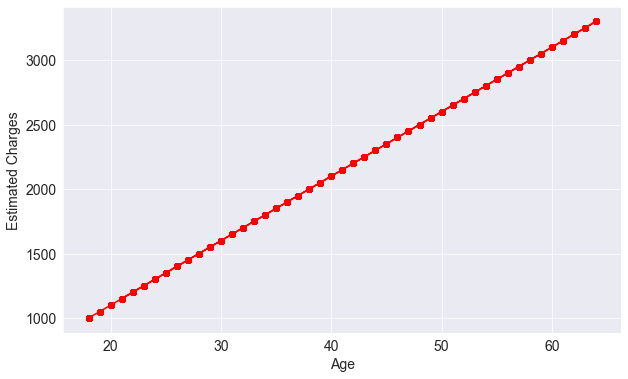

In [58]:
plt.plot(ages, estimated_charges, 'r-o');
plt.xlabel('Age');
plt.ylabel('Estimated Charges');

As expected, the points lie on a straight line. 

We can overlay this line on the actual data, so see how well our _model_ fits the _data_.

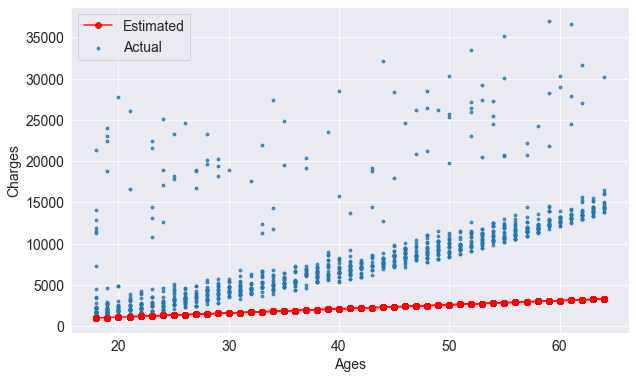

In [63]:
target = non_smoker_df.charges

plt.plot(ages, estimated_charges,'r-o',  alpha=0.9);
plt.scatter(ages,target, s=8, alpha = 0.8)
plt.xlabel('Ages')
plt.ylabel('Charges')
plt.legend(['Estimated', 'Actual'])

Clearly, the our estimates are quite poor and the line does not "fit" the data. However, we can try different values of $w$ and $b$ to move the line around. Let's define a helper function `try_parameters` which takes `w` and `b` as inputs and creates the above plot.

In [64]:
def try_parameters(w,b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    
    estimated_charges = estimate_charges(ages, w , b)
    plt.plot(ages, estimated_charges,'r-o',  alpha=0.9);
    plt.scatter(ages,target, s=8, alpha = 0.8)
    plt.xlabel('Ages')
    plt.ylabel('Charges')
    plt.legend(['Estimated', 'Actual'])

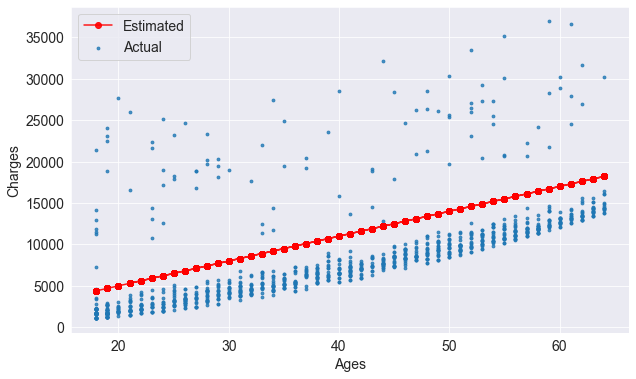

In [75]:
try_parameters(300,-1000)

As we change the values, of $w$ and $b$ manually, trying to move the line visually closer to the points, we are _learning_ the approximate relationship between "age" and "charges". 

Wouldn't it be nice if a computer could try several different values of `w` and `b` and _learn_ the relationship between "age" and "charges"? To do this, we need to solve a couple of problems:

1. We need a way to measure numerically how well the line fits the points.

2. Once the "measure of fit" has been computed, we need a way to modify `w` and `b` to improve the the fit.

If we can solve the above problems, it should be possible for a computer to determine `w` and `b` for the best fit line, starting from a random guess.

### Loss/Cost Function

We can compare our model's predictions with the actual targets using the following method:

* Calculate the difference between the targets and predictions (the differenced is called the "residual")
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.
* Take the square root of the result

The result is a single number, known as the **root mean squared error** (RMSE).

Let's define a function to compute the RMSE.

In [76]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

In [78]:
targets = non_smoker_df['charges']
predictions = estimate_charges(ages, w, b)

In [79]:
rmse(targets, predictions)

8461.949562575493

Here's how we can interpret the above number: *On average, each element in the prediction differs from the actual target by \\$8461*. 

The result is called the *loss* because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

Let's modify the `try_parameters` functions to also display the loss.

In [84]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    
    predictions = estimate_charges(ages, w, b)
    
    plt.plot(ages, predictions, 'r-o', alpha=0.8);
    plt.scatter(ages, target, s=8, alpha = 0.8);
    plt.xlabel('Ages')
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual'])
    
    loss = rmse(target, predictions)
    print('RMSE Loss: ', loss)

RMSE Loss:  4956.973980899423


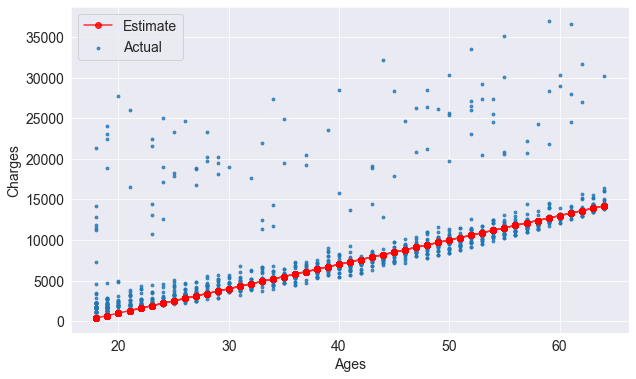

In [96]:
try_parameters(300,-5000)

### Linear Regression using Scikit-learn

In practice, you'll never need to implement either of the above methods yourself. You can use a library like `scikit-learn` to do this for you. 

Let's use the `LinearRegression` class from `scikit-learn` to find the best fit line for "age" vs. "charges" using the ordinary least squares optimization technique.

In [99]:
from sklearn.linear_model import LinearRegression

First, we create a new model object.

In [100]:
model = LinearRegression()

Next, we can use the `fit` method of the model to find the best fit line for the inputs and targets.

In [101]:
help(model.fit)

Help on method fit in module sklearn.linear_model._base:

fit(X, y, sample_weight=None) method of sklearn.linear_model._base.LinearRegression instance
    Fit linear model.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training data.
    
    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values. Will be cast to X's dtype if necessary.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Individual weights for each sample.
    
        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.
    
    Returns
    -------
    self : object
        Fitted Estimator.



Not that the input `X` must be a 2-d array, so we'll need to pass a dataframe, instead of a single column.

In [103]:
inputs = non_smoker_df[['age']]
targets = non_smoker_df.charges
print('input.shape : ', inputs.shape)
print('targets.shape :', targets.shape)

input.shape :  (1064, 1)
targets.shape : (1064,)


Let's fit the model to the data.

In [104]:
model.fit(inputs, targets)

LinearRegression()

Let compute the predictions for the entire set of inputs

In [106]:
predictions  = model.predict(inputs)
predictions

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

In [107]:
rmse(targets, predictions)

4662.505766636395

Seems like our prediction is off by $4000 on average, which is not too bad considering the fact that there are several outliers.

The parameters of the model are stored in the `coef_` and `intercept_` properties.

In [108]:
model.coef_

array([267.24891283])

In [110]:
model.intercept_

-2091.4205565650864

Let's visualize the line created by the above parameters.

RMSE Loss:  4662.505766636395


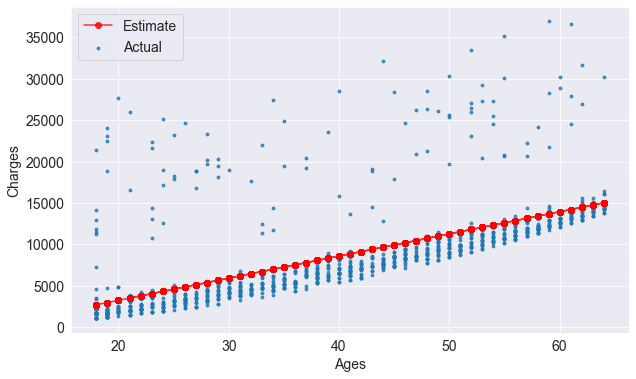

In [112]:
try_parameters(model.coef_, model.intercept_)

Indeed the line is quite close to the points. It is slightly above the cluster of points, because it's also trying to account for the outliers. 

Use the [`SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) class from `scikit-learn` to train a model using the stochastic gradient descent technique. Make predictions and compute the loss. Do you see any difference in the result?

In [113]:
from sklearn.linear_model import SGDRegressor

In [115]:
gradient_model = SGDRegressor()

In [117]:
gradient_fit = gradient_model.fit(inputs,targets)
gradient_fit

SGDRegressor()

In [120]:
gradient_predictions = gradient_model.predict(inputs)
gradient_predictions

array([-1927.92570435,   518.00726095,  1740.97374361, ...,
       -1927.92570435, -1927.92570435, -1194.14581476])

In [121]:
rmse(targets, gradient_predictions)

6940.66227883005

Compare to Linear Regression model, the stochastic gradient descent technique shows more loss almost 2900 more.

### Linear Regression for single feature ( Smoker )

In [126]:
smoker_df = medical_df[medical_df['smoker'] == 'yes']

In [127]:
model_smoker_regression = LinearRegression()

<AxesSubplot:xlabel='age', ylabel='charges'>

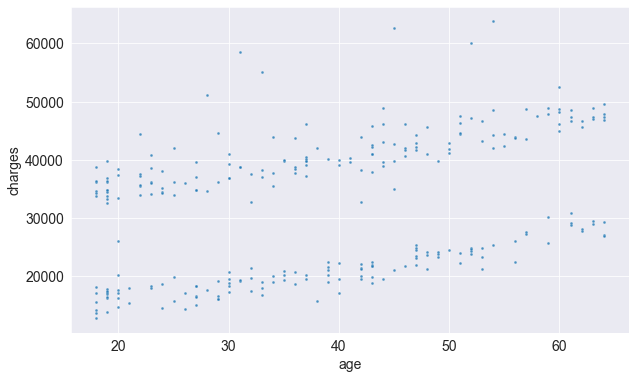

In [129]:
sns.scatterplot(data=smoker_df, x='age', y='charges', s=8, alpha=0.8)

In [163]:
smoker_age = smoker_df.age

In [184]:
def estimates(smoke_age, w, b):
    return w * smoke_age + b

In [165]:
estimate_charges_smoke = estimates(smoker_age, 100,2000)
estimate_charges_smoke

0       3900
11      8200
14      4700
19      5000
23      5400
        ... 
1313    3900
1314    5000
1321    8200
1323    6200
1337    8100
Name: age, Length: 274, dtype: int64

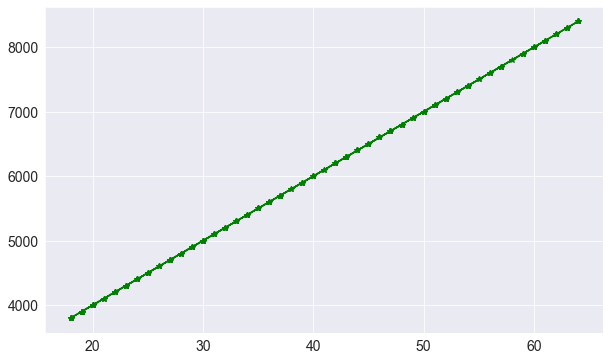

In [185]:
plt.plot(smoker_age,estimate_charges_smoke, 'g-*')

In [181]:
def smoker_rmse(smoker_targets, smoker_prediction):
    return np.sqrt(np.mean(np.square(smoker_targets - smoker_prediction)))

In [188]:
smoker_targets = smoker_df['charges']
smoker_prediction = estimates(smoker_age, w, b)

In [191]:
def smoker_try_parameters(w, b):
    smoker_age = smoker_df.age
    targets_charges_smoker = smoker_df.charges
    
    predictions_smoker_charge = estimates(smoker_age, w, b)
    
    plt.plot(smoker_age, predictions_smoker_charge, 'g-*', alpha = 0.9)
    plt.scatter(smoker_age,targets_charges_smoker, s=9, alpha = 0.8);
    plt.xlabel('Ages')
    plt.ylabel('Charges')
    plt.legend(['Estimated', 'Actual'])
    
    losses = smoker_rmse(targets_charges_smoker,predictions_smoker_charge)
    print('RMSE Loss: ', losses)

RMSE Loss:  13354.753888010619


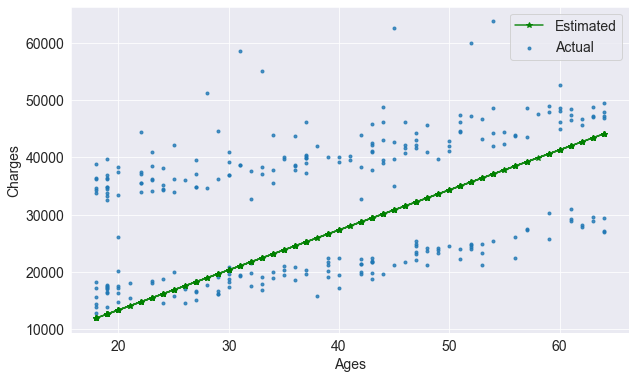

In [202]:
smoker_try_parameters(700,-700)

In [173]:
input_smoke_age = smoker_df[['age']]
target_smoke_charges = smoker_df.charges

In [174]:
model_smoker_regression.fit(input_smoke_age,target_smoke_charges)

LinearRegression()

In [203]:
predicted_smoker_charges = model_smoker_regression.predict(input_smoke_age)

In [177]:
model_smoker_regression.coef_

array([305.23760211])

In [179]:
model_smoker_regression.intercept_

20294.12812691597

RMSE Loss:  10711.00334810241


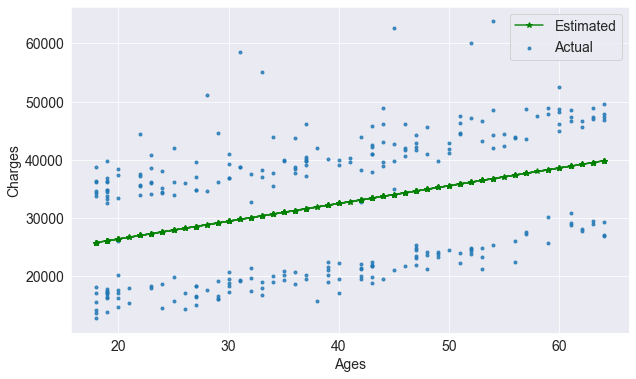

In [204]:
smoker_try_parameters(model_smoker_regression.coef_ , model_smoker_regression.intercept_)

## Linear Regression using Multiple Features

So far, we've used on the "age" feature to estimate "charges". Adding another feature like "bmi" is fairly straightforward. We simply assume the following relationship:

$charges = w_1 \times age + w_2 \times bmi + b$

We need to change just one line of code to include the BMI.

In [205]:
inputs_MF = smoker_df[['age','bmi']]
targets_MF = smoker_df.charges

In [206]:
model_MF = LinearRegression()

In [207]:
model_MF.fit(inputs_MF,targets_MF)

LinearRegression()

In [208]:
predictions_MF = model_MF.predict(inputs_MF)

In [209]:
model_MF.coef_

array([ 266.29222371, 1438.09098289])

In [210]:
model_MF.intercept_

-22367.449727751246

In [211]:
Loss_MF = rmse(targets_MF, predictions_MF)
print('RMSE LOSS: ', Loss_MF)

RMSE LOSS:  5722.782238884456


As you can see, adding the BMI seems to reduce the loss by much, as the BMI has a very strong correlation with charges, especially for smokers.

In [212]:
smoker_df.charges.corr(smoker_df.bmi)

0.8064806070155403

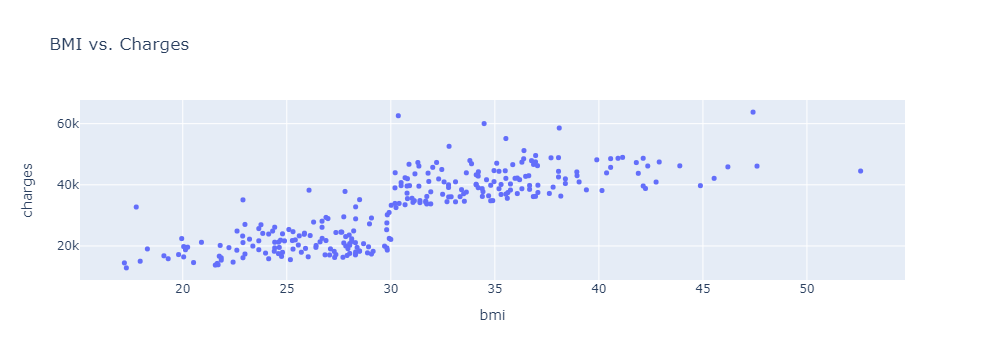

In [213]:
fig = px.scatter(smoker_df, x ='bmi', y = 'charges', title = 'BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

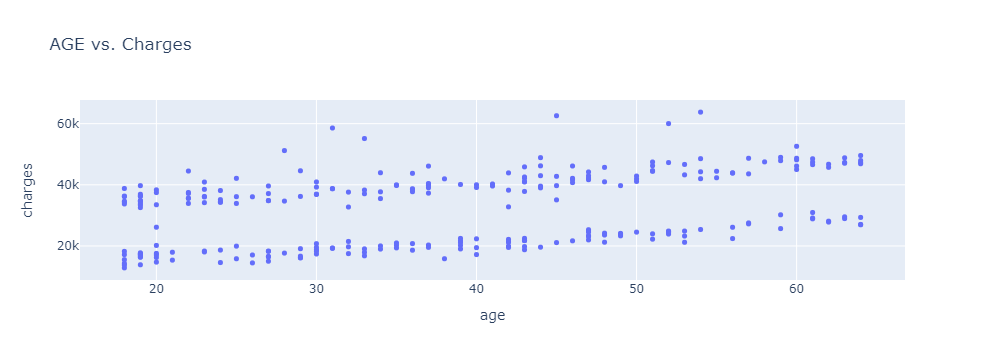

In [226]:
fig = px.scatter(smoker_df, x ='age', y = 'charges', title = 'AGE vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

## Linear Regression for single feature bmi

In [217]:
inputs_bmi = medical_df[['bmi']]
targets_bmi = medical_df.charges

In [218]:
model_bmi = LinearRegression()

In [219]:
model_bmi.fit(inputs_bmi, targets_bmi)

LinearRegression()

In [220]:
predictions_bmi = model_bmi.predict(inputs_bmi)

In [221]:
Loss_bmi = rmse(targets_bmi, predictions_bmi)
print('RMSE Loss : ', Loss_bmi)

RMSE Loss :  11864.986308399499


In [222]:
bmi_in = medical_df.bmi

In [223]:
def estimate_bmi(bmi_in, w, b):
    return bmi_in * w + b

In [224]:
def bmi_try_parameters(w, b):
    bmi = medical_df.bmi
    targets_bmi = medical_df.charges
    
    predictions_bmi = estimate_bmi(bmi, w, b)
    
    plt.plot(bmi, predictions_bmi, 'g-*', alpha = 0.9)
    plt.scatter(bmi,targets_bmi, s=9, alpha = 0.8);
    plt.xlabel('BMI')
    plt.ylabel('Charges')
    plt.legend(['Estimated', 'Actual'])
    
    losses = rmse(targets_bmi,predictions_bmi)
    print('RMSE Loss: ', losses)

RMSE Loss:  11864.986308399499


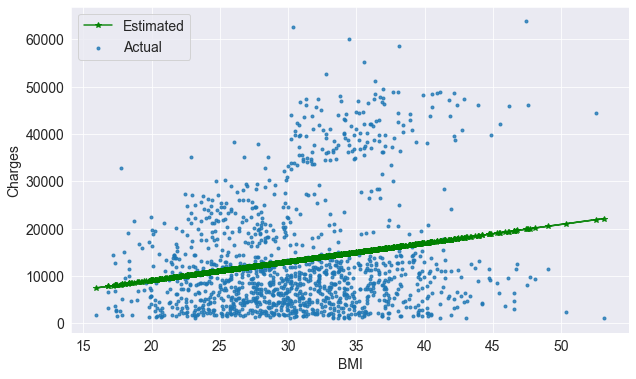

In [225]:
bmi_try_parameters(model_bmi.coef_, model_bmi.intercept_)

## Using Categorical Features for Machine Learning

So far we've been using only numeric columns, since we can only perform computations with numbers. If we could use categorical columns like "smoker", we can train a single model for the entire dataset.

To use the categorical columns, we simply need to convert them to numbers. There are three common techniques for doing this:

1. If a categorical column has just two categories (it's called a binary category), then we can replace their values with 0 and 1.
2. If a categorical column has more than 2 categories, we can perform one-hot encoding i.e. create a new column for each category with 1s and 0s.
3. If the categories have a natural order (e.g. cold, neutral, warm, hot), then they can be converted to numbers (e.g. 1, 2, 3, 4) preserving the order. These are called ordinals

## Binary Categories

The "smoker" category has just two values "yes" and "no". Let's create a new column "smoker_code" containing 0 for "no" and 1 for "yes".

<AxesSubplot:xlabel='smoker', ylabel='charges'>

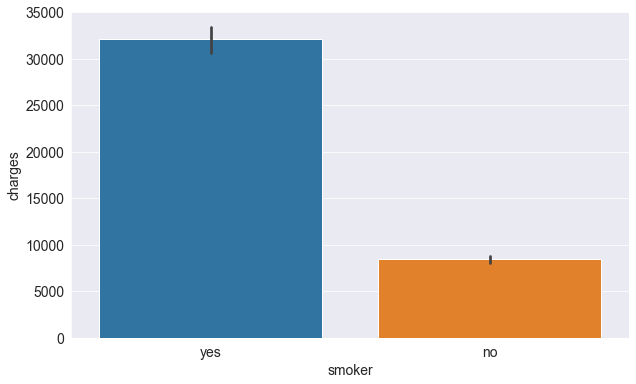

In [228]:
sns.barplot(data = medical_df, x = 'smoker', y = 'charges')

In [229]:
smoker_code = {'no' : 0, 'yes' : 1}
medical_df['smoker_code'] = medical_df.smoker.map(smoker_code)

In [230]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0
1334,18,female,31.920,0,no,northeast,2205.98080,0
1335,18,female,36.850,0,no,southeast,1629.83350,0
1336,21,female,25.800,0,no,southwest,2007.94500,0


We can now use the `smoker_df` column for linear regression.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + b$

In [231]:
input_values = medical_df[['age', 'bmi', 'children', 'smoker_code']]
target_values = medical_df.charges

In [232]:
model_CF = LinearRegression()

In [233]:
model_CF.fit(input_values,target_values)

LinearRegression()

In [234]:
predictions_CF = model_CF.predict(input_values)

In [238]:
from sklearn.metrics import r2_score
r2_score(target_values, predictions_CF)

0.749694530346479

In [240]:
rmse(target_values, predictions_CF)

6056.439217188081

The loss reduces from `11355` to `6056`, almost by 50%! This is an important lesson: never ignore categorical data.


### One-hot Encoding

The "region" column contains 4 values, so we'll need to use hot encoding and create a new column for each region.

<AxesSubplot:xlabel='region', ylabel='charges'>

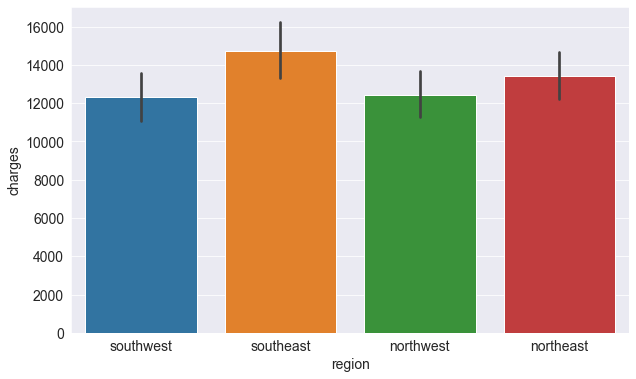

In [241]:
sns.barplot(data = medical_df, x = 'region', y = 'charges')

In [242]:
from sklearn import preprocessing
encode = preprocessing.OneHotEncoder()
encode.fit(medical_df[['region']])
encode.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [243]:
one_hot = encode.transform(medical_df[['region']]).toarray()
one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [246]:
medical_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

In [247]:
input_values1 = medical_df[['age', 'bmi', 'children', 'smoker_code', 'northeast', 'northwest', 'southeast', 'southwest']]
target_values1 = medical_df.charges

In [249]:
model_all = LinearRegression()

In [250]:
model_all.fit(input_values1,target_values1)

LinearRegression()

In [251]:
predictions_all = model_all.predict(input_values1)

In [252]:
rmse(target_values1, predictions_all)

6042.033215394104

Once again, this leads to a fairly small reduction in the loss.

In [253]:
r2_score(target_values1, predictions_all)

0.7508838801843356

## Model Improvements

Let's discuss and apply some more improvements to our model.

### Feature Scaling

Recall that due to regulatory requirements, we also need to explain the rationale behind the predictions our model. 

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

To compare the importance of each feature in the model, our first instinct might be to compare their weights. 

In [254]:
model_all.coef_

array([  256.97358248,   338.66463761,   474.56646951, 23836.30050226,
         586.47922829,   234.2971161 ,  -447.88089913,  -372.89544526])

In [255]:
model_all.intercept_

-12576.74910793317

We can apply scaling using the StandardScaler class from `scikit-learn`.

In [259]:
from sklearn.preprocessing import StandardScaler

In [263]:
numeric_cols = ['age', 'bmi', 'children']
scaler = StandardScaler()
scaler.fit(medical_df[numeric_cols])

StandardScaler()

In [264]:
scaler.mean_

array([39.20702541, 30.66339686,  1.09491779])

In [265]:
scaler.var_

array([197.25385199,  37.16008997,   1.45212664])

In [268]:
scaler_inputs = scaler.transform(medical_df[numeric_cols])
scaler_inputs

array([[-1.43876426, -0.45332   , -0.90861367],
       [-1.50996545,  0.5096211 , -0.07876719],
       [-0.79795355,  0.38330685,  1.58092576],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367],
       [-1.29636188, -0.79781341, -0.90861367],
       [ 1.55168573, -0.26138796, -0.90861367]])

These can now we combined with the categorical data

In [269]:
cat_cols = ['smoker_code', 'northeast','northwest', 'southeast', 'southwest']
categorical_data = medical_df[cat_cols].values

In [272]:
inp = np.concatenate((scaler_inputs, categorical_data), axis = 1)
tar = medical_df.charges

In [273]:
models = LinearRegression().fit(inp, tar)

In [274]:
predictions = models.predict(inp)

In [275]:
rmse(tar, predictions)

6042.033215394104

In [276]:
weights_df = pd.DataFrame( {
    'feature': np.append(numeric_cols + cat_cols, 1),
    'weight' : np.append(models.coef_, models.intercept_)
})
weights_df

,feature,weight
0,age,3609.119197
1,bmi,2064.468352
2,children,571.872609
3,smoker_code,23836.300502
4,northeast,586.479228
5,northwest,234.297116
6,southeast,-447.880899
7,southwest,-372.895445
8,1,8402.640125


As you can see now, the most important feature are:

1. Smoker
2. Age
3. BMI

### Creating a Test Set

Models like the one we've created in this tutorial are designed to be used in the real world. It's common practice to set aside a small fraction of the data (e.g. 10%) just for testing and reporting the results of the model.

In [277]:
from sklearn.model_selection import train_test_split

In [282]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(input_values1, target_values1, test_size = 0.2)

In [283]:
# Create and train the model
model = LinearRegression().fit(inputs_train, targets_train)

# Generate predictions
predictions_test = model.predict(inputs_test)

# Compute loss to evalute the model
loss = rmse(targets_test, predictions_test)
print('Test Loss:', loss)

Test Loss: 5931.386535380577


In [284]:
# Generate predictions
predictions_train = model.predict(inputs_train)

# Compute loss to evalute the model
loss = rmse(targets_train, predictions_train)
print('Training Loss:', loss)

Training Loss: 6081.5325604699165


The test loss is almost same as train. That means our results are in good agreement.